Identifying direction changes in the buoy drift track allows us to see when the sea ice responded to the wind difference at the storm front.

In [1]:
import proplot as pplt
import pandas as pd
import numpy as np
import os

def find_cusps(buoy, timeslice, buoy_dict):
    """Identify cusps in the buoy track by use of the
    times with maximum bearing change. Threshold is a
    20 degree shift in 30 minutes."""
    
    # Convert direction change from previous time step into -180 to 180.
    x = (buoy_dict[buoy].bearing - buoy_dict[buoy].bearing.shift(1) + 180) % 360 - 180
    sharp_changes = (np.abs(x.loc[timeslice]) > 20) & (np.abs(x.loc[timeslice]) == np.abs(x.loc[timeslice]).rolling(
        center=True, window=15).max())
    cusps = x.loc[timeslice][sharp_changes].index
    return list(cusps)

def distance_and_bearing(buoy_df, reference_df):
    """At each time step, computes the distance and bearing from reference_df to buoy_df.
    Returns a dataframe identical to buoy_df but with added columns r, theta with units in meters and degrees."""
    import pyproj
    geod = pyproj.Geod(ellps='WGS84')
    merged_data = pd.merge(buoy_df, reference_df, left_index=True, right_index=True)
    if len(merged_data) == 0:
        return merged_data
    else:
        fa, ba, distance = geod.inv(merged_data.longitude_y.values, 
                                    merged_data.latitude_y.values,
                                    merged_data.longitude_x.values, 
                                    merged_data.latitude_x.values)
    return pd.DataFrame({'latitude': merged_data.latitude_x.values,
                         'longitude': merged_data.longitude_x.values,
                         'distance': distance.round(0),
                         'bearing': fa.round(5)}, index=merged_data.index
                          )



In [2]:

# List the available drift tracks, including only CSV files.
files = os.listdir('../Data/DriftTracksInterpolated/')
files = [f for f in files if f.split('.')[-1] == 'csv']

# Read the buoy metadata and add the filename to the list.
buoy_info = pd.read_csv('../Data/Metadata/dn_buoy_metadata.csv', index_col='Sensorweb ID')
buoy_info['Sensorweb ID'] = buoy_info.index.values
buoy_info.index.names = ['']
buoy_info['filename'] = ''
for buoy in buoy_info.index:
    buoy_info.loc[buoy, 'filename'] = '_'.join(
        [str(x) for x in buoy_info.loc[
            buoy, ['DN Station ID', 'IMEI', 'Sensorweb ID']]]) + '.csv'
    
file_present = np.array([f in files for f in buoy_info.filename])
buoy_info = buoy_info[file_present]

# Read in the buoy data, checking the median sampling frequency.
# Skip buoys with median sampling frequency over two hours.
buoy_data = {}
for buoy in buoy_info.index:
    filename = buoy_info.loc[buoy, 'filename']
    buoy_data[buoy] = pd.read_csv('../Data/DriftTracksInterpolated/' + filename, index_col='datetime', parse_dates=True)
buoy_data['CO1'] = pd.read_csv('../Data/DriftTracksInterpolated/CO1.csv', index_col='datetime', parse_dates=True)

In [3]:
iabp_data = {}
iabp_files = os.listdir('../Data/IABP/')
buoy_ids = [int(x.split('.')[0]) for x in iabp_files]

In [4]:
print(len(buoy_ids))
buoy_ids = [x for x in buoy_ids if x not in buoy_info.IMEI.values.astype(int)]

297


In [5]:
idx = 0
iabp_buoys = {}
for buoy in buoy_ids:
    df = pd.read_csv('../Data/IABP/' + str(buoy) + '.csv', index_col=0)
    df['datetime'] = pd.to_datetime(df['datetime'].values)
    df.set_index('datetime', inplace=True)
    df = df.sort_index()
    if len(df.loc[timeslice]) > 0:
        iabp_buoys[buoy] = df.copy()

NameError: name 'timeslice' is not defined

# Thing to check/fix
Need to find which buoys have jumps in the tracks that would cause problems. Looks like there are a bunch of buoys in here that are in MOSAiC

In [ ]:
fig, ax = pplt.subplots(proj='npstere')
timeslice=slice(pd.to_datetime('2020-01-30 00:00'), pd.to_datetime('2020-02-05 00:00'))
for buoy in iabp_buoys:
    if len(iabp_buoys[buoy].loc[timeslice]) > 0:
        ax.format(boundinglat=75, coast=True)
        ax.plot(iabp_buoys[buoy].loc[timeslice].longitude, iabp_buoys[buoy].loc[timeslice].latitude)

In [6]:
def get_list_of_buoys(timeslice, buoy_data):
    """Returns list of buoys with at least 90% of the data present"""
    data_len = []
    for buoy in buoy_data:
        data_len.append(buoy_data[buoy].loc[timeslice].shape[0])
    return [buoy for buoy, n in zip(buoy_data, data_len) if n > 0.9 * max(data_len)]
timeslice = slice(pd.to_datetime('2020-01-31 00:00'), pd.to_datetime('2020-02-02 00:00'))
buoys = get_list_of_buoys(timeslice, buoy_data)


In [ ]:
import xarray as xr
cafs = xr.open_dataset('../Data/Drifts_31Jan-1Feb2020_30min.nc')

In [ ]:
pb = []
k = 0
pseudo_buoys = {}
for idx in range(21):
    for jdx in range(21):
        pb = str(k).zfill(3)
        if idx == 10:
            if jdx == 10:
                print(pb)
        pseudo_buoys[pb] = cafs.isel(gridj=jdx, gridi=idx)[['drift_lat', 'drift_lon']].to_dataframe()
        time = pd.to_datetime('2020-01-31 12:00') + pd.to_timedelta(pseudo_buoys[pb].index, unit='H')
        pseudo_buoys[pb].index = time
        pseudo_buoys[pb].rename({'drift_lat': 'latitude', 'drift_lon': 'longitude'}, axis=1, inplace=True)
        k += 1

In [ ]:
# Build function to switch from lat/lon to NP Stereographic
import pyproj
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC North Polar Stereographic
transformer = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

# Apply to interpolated buoy data and compute velocity (stereographic coordinates)
for buoy in pseudo_buoys:
    lon = pseudo_buoys[buoy]['longitude'].values
    lat = pseudo_buoys[buoy]['latitude'].values
    x, y = transformer.transform(lon, lat)
    pseudo_buoys[buoy]['x'] = x
    pseudo_buoys[buoy]['y'] = y

In [ ]:
def centered_velocity(xvar, yvar, data, dt=3600):
    """Assumes the rows are a datetime index with 30 min step size."""
    dx = data[xvar].shift(-1) - data[xvar].shift(1)
    dy = data[yvar].shift(-1) - data[yvar].shift(1)
    return dx/dt, dy/dt

# Compute velocity and convert into U and V, oceanographic convention
def compute_vel_acc(data):
    """Applies the centered_velocity function, projects velocities into u and v.
    Applies centered smoothing with window size."""
    data = data.copy()
    data['x'] = data.x.rolling(3, center=True).mean()
    data['y'] = data.y.rolling(3, center=True).mean()
    dxdt, dydt = centered_velocity('x', 'y', data=data)
    data['dxdt'] = dxdt.rolling(3, center=True).mean()
    data['dydt'] = dydt.rolling(3, center=True).mean()
    ddxddt, ddyddt = centered_velocity('dxdt', 'dydt', data=data)
    data['ddxddt'] = ddxddt.rolling(3, center=True).mean()
    data['ddyddt'] = ddyddt.rolling(3, center=True).mean()

    data['Nx'] = 1/np.sqrt(data['x']**2 + data['y']**2)*-data['x']
    data['Ny'] = 1/np.sqrt(data['x']**2 + data['y']**2)*-data['y']
    data['Ex'] = 1/np.sqrt(data['x']**2 + data['y']**2)*-data['y']
    data['Ey'] = 1/np.sqrt(data['x']**2 + data['y']**2)*data['x']

    data['u'] = data['Ex'] * data['dxdt'] + data['Ey'] * data['dydt']
    data['v'] = data['Nx'] * data['dxdt'] + data['Ny'] * data['dydt']
    data['du'] = data['Ex'] * data['ddxddt'] + data['Ey'] * data['ddyddt']
    data['dv'] = data['Nx'] * data['ddxddt'] + data['Ny'] * data['ddyddt']


    # Calculate angle, then change to 360
    heading = np.degrees(np.angle(data.u.values + 1j*data.v.values))
    heading = (heading + 360) % 360
    # Shift to direction from north instead of direction from east
    heading = 90 - heading
    heading = (heading + 360) % 360
    data['bearing'] = heading
    data['speed'] = np.sqrt(data['u']**2 + data['v']**2)
    return data.loc[:, ['latitude', 'longitude', 'x', 'y',
                        'dxdt', 'dydt', 'ddxddt', 'ddyddt', 'u', 'v', 'du', 'dv', 'bearing', 'speed']]

pseudo_buoys = {buoy: compute_vel_acc(pseudo_buoys[buoy]) for buoy in pseudo_buoys}

In [ ]:
buoy_data = {buoy: compute_vel_acc(buoy_data[buoy]) for buoy in buoy_data}

Curvature
$$K = \frac{|uv' - vu'|}{(u^2 + v^2)^{2/3}}$$

I have to figure out what's going on weird with the calculations of velocities and such.

In [ ]:
def K(data):
    """Computes the curvature K using the u, v, du, and dv.
    """
    numer = np.abs(data['u']*data['dv'] - data['v']*data['du'])
    denom = (data['u']**2 + data['v']**2)**(2/3)
    return numer/denom
    

In [ ]:
timeslice=slice('2020-01-31', '2020-02-04')
radii = pd.DataFrame({buoy: 1/K(pseudo_buoys[buoy].loc[timeslice]) for buoy in pseudo_buoys},
                 )

In [ ]:
timeslice=slice('2020-01-31', '2020-02-04')
radii_real = pd.DataFrame({buoy: 1/K(buoy_data[buoy].loc[timeslice]) for buoy in buoy_data},
                 )

In [ ]:
fig, ax = pplt.subplots(nrows=2, share=False, width=7, height=7)
for buoy in ['021', '030', '130', '150', '220']:
    rad = K(pseudo_buoys[buoy])
    print(buoy, pseudo_buoys[buoy]['du'].min())
    ax[0].plot(rad.index, 1/rad, zorder=0)
    ax[0].scatter(rad.index, 1/rad, c=pseudo_buoys[buoy]['du'], edgecolor='k')
    ax[0].format(ylim=(5e3, 60e3))
    ax[1].scatter(pseudo_buoys[buoy]['x'], pseudo_buoys[buoy]['y'],
                  c=1/rad, edgecolor='k', cmap='bwr', vmin=10e3, vmax=60e3)
#     ax[1].plot(pseudo_buoys[buoy]['x'].rolling(3, center=True).mean(),
#               pseudo_buoys[buoy]['y'].rolling(3, center=True).mean(), marker='.')
    #ax[2].plot(rad.index, pseudo_buoys[buoy]['u']*pseudo_buoys[buoy]['dv'] - pseudo_buoys[buoy]['v']*pseudo_buoys[buoy]['du'])
    # ax[2].plot(rad.index, pseudo_buoys[buoy]['dydt'])
    # ax[2].plot(rad.index, pseudo_buoys[buoy]['dxdt'])

I think the idea is still worth looking into, but that my calculation of K is off. I'm not sure what's going on, but on some plots it seems right and others it doesn't.

In [ ]:
date1 = pd.to_datetime('2020-01-31 12:00')
date2 = pd.to_datetime('2020-02-01 12:00')
timeslice=slice(date1, date2)
#full_set = get_list_of_buoys(timeslice, buoy_data)
cusp_data = {}
for buoy in pseudo_buoys:
    cusp_data[buoy] = find_cusps(buoy, timeslice, pseudo_buoys)
    

In [ ]:
find_cusps('209', timeslice, pseudo_buoys)

In [7]:
def find_cusps(buoy, timeslice, buoy_dict):
    """Identify cusps in the buoy track by use of the
    times with maximum bearing change. Threshold is a
    20 degree shift in 30 minutes."""
    
    # Convert direction change from previous time step into -180 to 180.
    x = (buoy_dict[buoy].bearing - buoy_dict[buoy].bearing.shift(1) + 180) % 360 - 180
    x = x.rolling(3, center=True).mean()
    sharp_changes = (np.abs(x.loc[timeslice]) > 10) & (np.abs(x.loc[timeslice]) == np.abs(x.loc[timeslice]).rolling(
        center=True, window=15).max())
    cusps = x.loc[timeslice][sharp_changes].index
    return list(cusps)

In [ ]:
fig, ax = pplt.subplots(ncols=2, share=False)
for buoy in [b for b in pseudo_buoys][10:15]:
    x = (pseudo_buoys[buoy].bearing - pseudo_buoys[buoy].bearing.shift(1) + 180) % 360 - 180

    ax[0].plot(x.rolling(3, center=True).mean())
    ax[1].plot(pseudo_buoys[buoy].x.values - pseudo_buoys[buoy].x.values[0],
               pseudo_buoys[buoy].y.values - pseudo_buoys[buoy].y.values[0])

In [ ]:
center_idx = '220'
date = '2020-02-01 00:00'
cusps = pd.Series({buoy: cusp_data[buoy] for buoy in pseudo_buoys})
for idx in cusps.index:
    if len(cusps[idx]) == 0:
        cusps[idx] = pd.NaT
    else:
        cusps[idx] = cusps[idx][0]


In [ ]:
def grab_path(date, buoy, buoy_dict):
    """Returns the buoy path relative to date."""
    dt = pd.to_timedelta(6, unit='H')
    times = slice(date - dt, date + dt)
    x = buoy_dict[buoy].loc[times]['x']
    y = buoy_dict[buoy].loc[times]['y']
    return x - x[date], y - y[date]

In [ ]:
dfx = pd.DataFrame({buoy: pseudo_buoys[buoy].loc[date, 'x'] for buoy in pseudo_buoys}, index=[date])
dfy = pd.DataFrame({buoy: pseudo_buoys[buoy].loc[date, 'y'] for buoy in pseudo_buoys}, index=[date])
dfx = dfx.loc[:, ::2]
dfy = dfy.loc[:, ::2]

In [ ]:
dt = pd.Series([x - cusps['220'] for x in cusps.dropna()], index=cusps.dropna().index)
dt = (dt.dt.days + dt.dt.seconds / (24*60*60)) * 24

In [ ]:
fig, ax = pplt.subplots(width=7, height=6)
x0 = pseudo_buoys[center_idx].loc[date, 'x']
y0 = pseudo_buoys[center_idx].loc[date, 'y']
m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0, s=5)#, c=dt.values.squeeze(), edgecolor='k',N=10, vmin=-2, vmax=2, cmap='ColdHot',)
for buoy in cusps.index[::2]:
    x, y = grab_path(pd.to_datetime(date), buoy, pseudo_buoys)
    x += dfx[buoy].values - x0
    y += dfy[buoy].values - y0
    ax.plot(x, y, color='k', lw=0, marker='.', markersize=1)

m = ax.scatter(dfx.loc[:, dt.index].values.squeeze() - x0,
           dfy.loc[:, dt.index].values.squeeze() - y0,
               c=dt.values.squeeze(), edgecolor='k',N=20, vmin=-5, vmax=5, cmap='ColdHot', zorder=3)
    

ax.colorbar(m, label='Hours offset from ' +  cusps['220'].strftime('%Y-%m-%d %H:%M'))
#ax.format(ylim=(87,88), xlim=(90,105))
ax.format(title='First estimate of timing of direction change')
# fig.save('../Images/CuspTracks.jpg', dpi=300)

In [ ]:
radii.dropna(how='all')

In [ ]:
fig, ax = pplt.subplots()
ax.plot(real_buoys['CO1']['longitude'].loc[timeslice],
       real_buoys['CO1']['latitude'].loc[timeslice])

In [ ]:
timeslice=slice('2020-01-30', '2020-02-04')
radii = pd.DataFrame({buoy: 1/K(buoy_data[buoy].loc[timeslice]) for buoy in buoy_data},
                 )
fig, ax = pplt.subplots(width=12, height=6)
ax.pcolormesh(radii.dropna(how='all', axis=1)/1e3, cmap='spectral', vmin=5, vmax=90, colorbar='r')
ax.format(xformatter='none', xticks='none')
ax.format(title='Radius of curvature (km)')

This isn't there yet, but I think the idea is coalescing. I want to identify the timing of the turnaround, the rate of the turnaround, and the radius of the turn in a way that is consistent across the array. I'm not certain this is the best approach, and I should do some of the math with the momentum equation to see what I should expect the terms to be. What it does look like is that the radius approach is picking out fairly consistent "events" across the whole array, and that there should be a possibility of using a threshold to pick out where turns are happening and a way to quantify how long it takes for the readjustment to take place.

In [ ]:
minima = radii.loc[slice('2020-01-31 20:00', '2020-02-01 06:00')].idxmin()
fig,ax = pplt.subplots(width=6, height=3)
df = radii.loc[slice('2020-01-31 20:00', '2020-02-01 06:00')]
for idx in df.columns:
    ax.plot(df.loc[:, idx])
    ax.format(yformatter='log', ylim=(1, 1e5))

In [ ]:
dt = (minima - minima['CO1']).dt.days + (minima - minima['CO1']).dt.seconds / (24*3600)
dt = -dt.dropna()*24
x = [buoy_data[b].loc[minima['CO1'], 'longitude'] for b in dt.index]
y = [buoy_data[b].loc[minima['CO1'], 'latitude'] for b in dt.index]
fig, ax = pplt.subplots(width=6)
ax.format(title='Time offset (positive = earlier than CO1)')
ax.scatter(x, y, c=dt.values, cmap='ColdHot', vmin=-3, vmax=3, colorbar='r', N=15, edgecolor='k')

In [ ]:
# What might be nice is to show all the tracks and do a bokeh slider highlighting the current track

In [ ]:
fig, ax = pplt.subplots(width=7, height=6)
x0 = pseudo_buoys[center_idx].loc[date, 'x']
y0 = pseudo_buoys[center_idx].loc[date, 'y']
m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0, s=5)#, c=dt.values.squeeze(), edgecolor='k',N=10, vmin=-2, vmax=2, cmap='ColdHot',)
for buoy in cusps.index[::2]:
    x, y = grab_path(pd.to_datetime(date), buoy, pseudo_buoys)
    x += dfx[buoy].values - x0
    y += dfy[buoy].values - y0
    ax.plot(x, y, color='k', lw=0, marker='.', markersize=1)

m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0,
               c=radii[dfx.columns], edgecolor='k',N=20, vmin=5e3, vmax=30e3, cmap='spectral', zorder=3)
    

ax.colorbar(m, label='Hours offset from ' +  cusps['220'].strftime('%Y-%m-%d %H:%M'))
#ax.format(ylim=(87,88), xlim=(90,105))
ax.format(title='First estimate of timing of direction change')
# fig.save('../Images/CuspTracks.jpg', dpi=300)

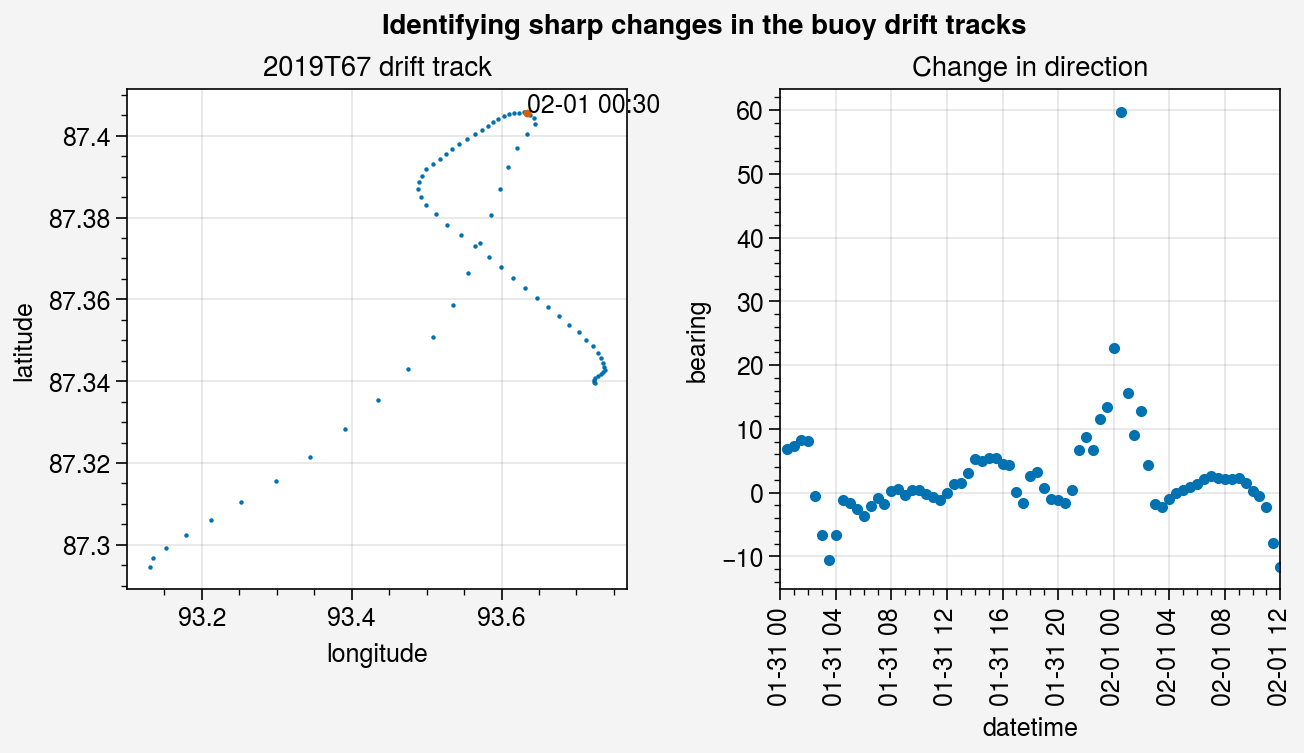

In [8]:
fig, axs = pplt.subplots(ncols=2, share=False)

date1 = pd.to_datetime('2020-01-31 00:00')
date2 = pd.to_datetime('2020-02-01 12:00')
timeslice=slice(date1, date2)
full_set = get_list_of_buoys(timeslice, buoy_data)
cusp_data = {}
for buoy in buoys:
    cusp_data[buoy] = find_cusps(buoy, timeslice, buoy_data)
buoy = '2019T67'
cusps = cusp_data[buoy]

axs[0].scatter(buoy_data[buoy].loc[timeslice].longitude,
           buoy_data[buoy].loc[timeslice].latitude, s=1)
axs[0].scatter(buoy_data[buoy].loc[timeslice].longitude.loc[cusps],
           buoy_data[buoy].loc[timeslice].latitude.loc[cusps], s=5)
for cusp in cusps:
    axs[0].text(buoy_data[buoy].loc[cusp, 'longitude'], buoy_data[buoy].loc[cusp, 'latitude'], text=cusp.strftime('%m-%d %H:%M'))


x = (buoy_data[buoy].loc[timeslice].bearing - buoy_data[buoy].loc[timeslice].bearing.shift(1) + 180) % 360 - 180
axs[1].plot(x, lw=0, marker='.')
axs.format(suptitle='Identifying sharp changes in the buoy drift tracks')
axs[0].format(title=buoy + ' drift track')
axs[1].format(title='Change in direction')   

In [ ]:
# pulling out the relative positions

In [9]:
buoys = [buoy for buoy in cusp_data if len(cusp_data[buoy]) > 0]

In [10]:
date = '2020-02-01 00:00'
dfx = pd.DataFrame({buoy: buoy_data[buoy].loc[date, 'x'] for buoy in buoys}, index=[date])
dfy = pd.DataFrame({buoy: buoy_data[buoy].loc[date, 'y'] for buoy in buoys}, index=[date])


In [11]:
cusps = pd.Series({buoy: cusp_data[buoy][0] for buoy in buoys})
dt = cusps - pd.to_datetime(date)
dt = (dt.dt.days + dt.dt.seconds / (24*60*60)) * 24

In [12]:
def grab_path(date, buoy, buoy_dict):
    """Returns the buoy path relative to date."""
    dt = pd.to_timedelta(6, unit='H')
    times = slice(date - dt, date + dt)
    x = buoy_dict[buoy].loc[times]['x']
    y = buoy_dict[buoy].loc[times]['y']
    return x - x[date], y - y[date]

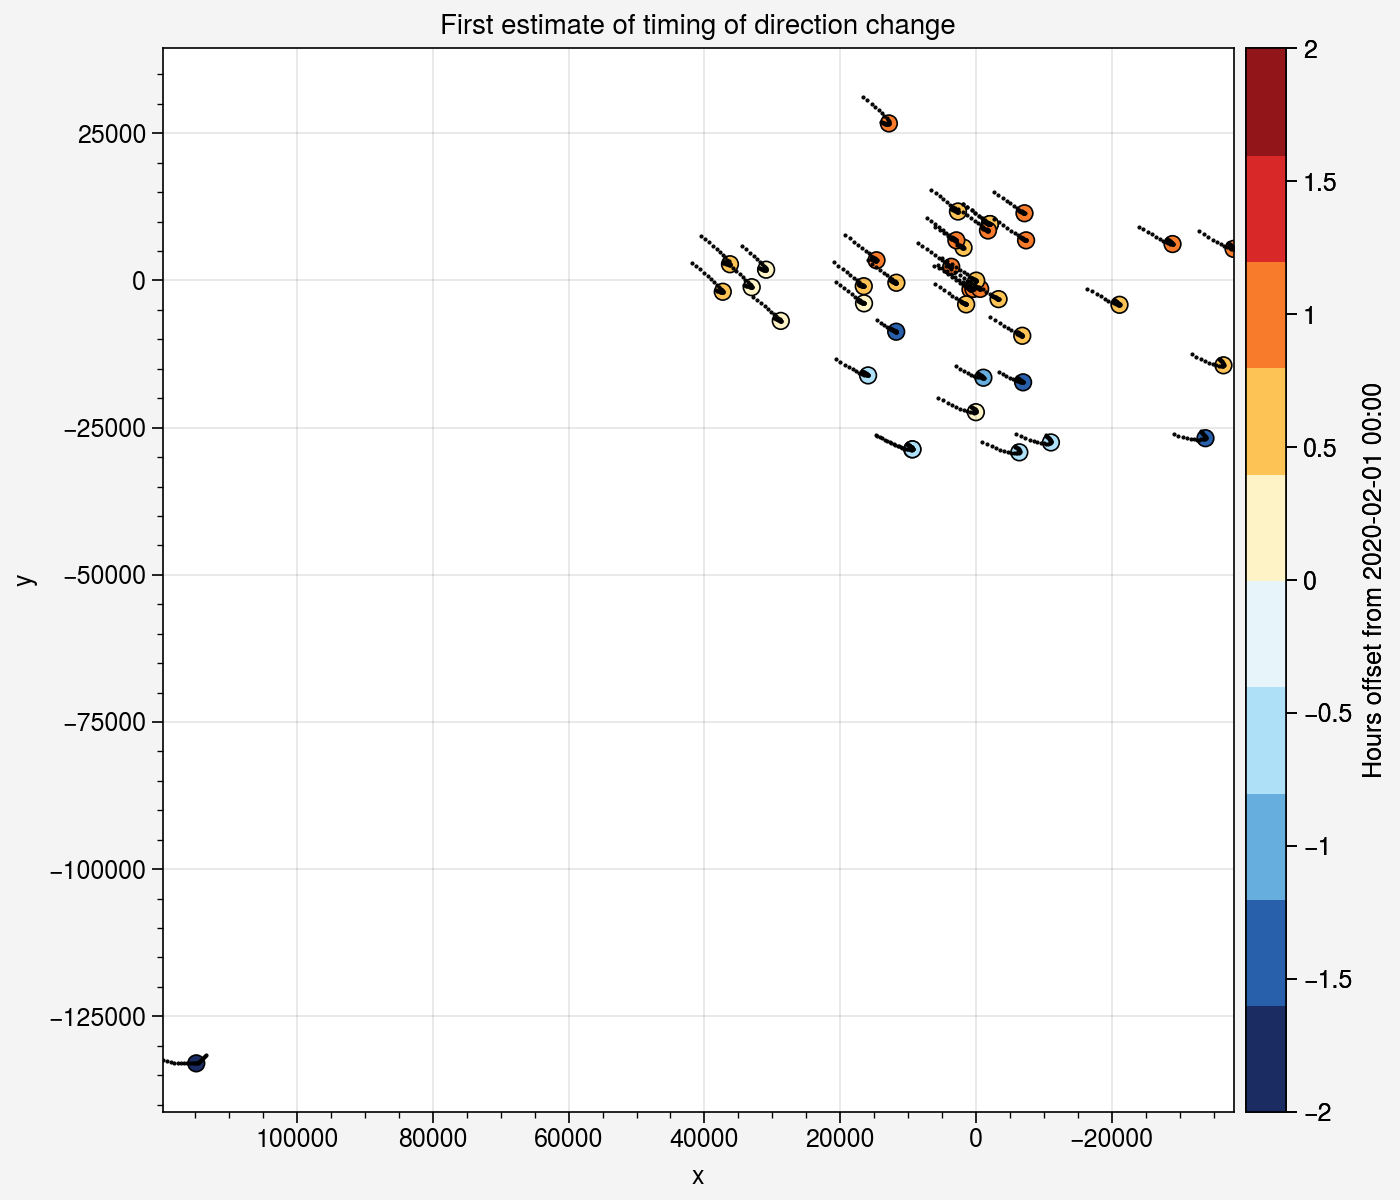

In [13]:
fig, ax = pplt.subplots(width=7, height=6)
x0 = buoy_data['CO1'].loc[cusps['CO1'], 'x']
y0 = buoy_data['CO1'].loc[cusps['CO1'], 'y']
m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0, c=dt.values.squeeze(), edgecolor='k', N=10, vmin=-2, vmax=2, cmap='ColdHot',)
for buoy in buoys:
    x, y = grab_path(cusps[buoy], buoy, buoy_data)
    x += dfx[buoy].values - x0
    y += dfy[buoy].values - y0
    ax.plot(x, y, color='k', lw=0, marker='.', markersize=1)
ax.colorbar(m, label='Hours offset from 2020-02-01 00:00')
#ax.format(ylim=(87,88), xlim=(90,105))
ax.format(title='First estimate of timing of direction change')
fig.save('../Images/CuspTracks.jpg', dpi=300)

In [ ]:
date = '2020-02-01 00:00'
def grab_path(date, buoy, buoy_dict):
    """Returns the buoy path relative to date."""
    dt = pd.to_timedelta(6, unit='H')
    times = slice(date - dt, date + dt)
    x = buoy_dict[buoy].loc[times]['longitude']
    y = buoy_dict[buoy].loc[times]['latitude']
    return x - x[date], y - y[date]
dfx = pd.DataFrame({buoy: buoy_data[buoy].loc[date, 'longitude'] for buoy in buoys}, index=[date])
dfy = pd.DataFrame({buoy: buoy_data[buoy].loc[date, 'latitude'] for buoy in buoys}, index=[date])

fig, ax = pplt.subplots(width=7, height=6)
x0 = buoy_data['CO1'].loc[cusps['CO1'], 'longitude']
y0 = buoy_data['CO1'].loc[cusps['CO1'], 'latitude']
m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0, c=dt.values.squeeze(), edgecolor='k', N=10, vmin=-2, vmax=2, cmap='ColdHot',)
for buoy in buoys:
    x, y = grab_path(cusps[buoy], buoy, buoy_data)
    x += dfx[buoy].values - x0
    y += dfy[buoy].values - y0
    ax.plot(x, y, color='k', lw=0, marker='.', markersize=1)
ax.colorbar(m, label='Hours offset from 2020-02-01 00:00')
#ax.format(ylim=(87,88), xlim=(90,105))
ax.format(title='First estimate of timing of direction change', xreverse=False)

In [ ]:
buoy_data['CO1'].loc[timeslice].x.plot(marker='.')

In [ ]:
# Select and save initial positions for Amy
date = '2020-01-31 12:00'


df_save = pd.DataFrame({buoy: buoy_data[buoy].loc[pd.to_datetime(date)] for buoy in buoys}).T.drop('CO1').loc[:, ['latitude', 'longitude']]
df_save = df_save.reset_index()
df_save.rename({'index': 'buoy_id'}, axis=1, inplace=True)
df_save['datetime'] = date
df_save.loc[:, ['datetime', 'latitude', 'longitude', 'buoy_id']].to_csv('buoy_location_2020-01-31_1200.csv')

In [ ]:
# get geo-grid
# Build function to switch from lat/lon to NP Stereographic
import pyproj
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC North Polar Stereographic
transformer = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)
lat0, lon0 = buoy_data['CO1'].loc[date, ['latitude', 'longitude']]

In [ ]:
new_df = pd.DataFrame({'x': np.ravel(X1), 'y': np.ravel(Y1)})
transformer2 = pyproj.Transformer.from_crs(projOut, projIn, always_xy=True)
lon1, lat1 = transformer2.transform(new_df['x'], new_df['y'])

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import CustomJS, Slider, Label, LabelSet, CustomJS, ColumnDataSource
from bokeh.layouts import column

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os

# Load Bokeh
output_notebook()

In [ ]:
timeslice = slice('2020-01-31 00:00', '2020-02-01 23:00')
dfx = pd.DataFrame({buoy: buoy_data[buoy].loc[timeslice, 'longitude'] for buoy in buoys})
dfy = pd.DataFrame({buoy: buoy_data[buoy].loc[timeslice, 'latitude'] for buoy in buoys})
dfx = (dfx.T - dfx['CO1']).T 
dfy = (dfy.T - dfy['CO1']).T 

source = ColumnDataSource(data=dict(x=dfx.iloc[0,:].values,
                                    y=dfy.iloc[0,:].values,
                                    name=list(dfx.columns.values))
                         )
source_co1 = ColumnDataSource(data=dict(
                                    x=[dfx.iloc[0,-1]],
                                    y=[dfy.iloc[0,-1]]))

sourcelist = [ColumnDataSource(data=dict(x=dfx.iloc[i,:].values,
                                    y=dfy.iloc[i,:].values,                                      
                                    name=list(dfx.columns.values))) for i in range(len(dfx))]
                                   
source_co1_list = [ColumnDataSource(data=dict(x=[dfx.iloc[i,-1]],
                                    y=[dfy.iloc[i,-1]])) for i in range(len(dfx))]
source_date = ColumnDataSource(data=dict(date=[dfx.index[0].strftime('%Y-%m-%d %H:%M')]))
source_date_list = [ColumnDataSource(data=dict(date=[dfx.index[i].strftime('%Y-%m-%d %H:%M')]))
                                                        for i in range(len(dfx))]

plot = figure(plot_width=600, plot_height=500, title='MOSAiC Distributed Network (Start: ' + date1.strftime('%Y-%m-%d') + ')')
plot.circle('x', 'y', source=source)
labels = LabelSet(x='x', y='y', text='name', source=source,
                 x_offset=1, y_offset=-1, render_mode='canvas', text_font_size='8pt')
plot.xaxis[0].axis_label='Distance from CO1 (degrees longitude)'
plot.yaxis[0].axis_label='Distance from CO1 (degrees latitude)'
plot.add_layout(labels)
slider = Slider(start=0, end=len(dfx), value=1, step=1, title="Timestep")

update_points = CustomJS(args=dict(source_curr=source,
                                  source_list=sourcelist,
                                  slider=slider), code="""
    var plot_i = cb_obj.value // This is an int
    
    // Now update the y-values for each x, based on the slider value
    source_curr.data['x'] = source_list[plot_i].data['x']
    source_curr.data['y'] = source_list[plot_i].data['y']
    source_curr.change.emit();
""")
print('Timesteps are 30 min, so 48 is 2020-02-01')
slider.js_on_change('value', update_points)
show(column(slider, plot))

In [ ]:
2019T64 - east side
2019O3 - west side

In [ ]:
# Getting sea level pressure data
import xarray as xr
ds_slp = xr.open_mfdataset(['../Data/ERA5/jan_msl.nc',
                            '../Data/ERA5/feb_msl.nc'])

In [ ]:
ds_10m = xr.open_dataset('../Data/ERA5/era5_hourly_10m_wind_2020_01-2020-02.nc')

In [ ]:
lon0 = dfx['CO1'].values
lat0 = dfy['CO1'].values

In [ ]:
ds_slp.sel(longitude=slice(90, 100),
                       latitude=slice(88, 87))['msl']

In [ ]:
fig, axs = pplt.subplots(width=12, height=4, ncols=3, share=False)
for ax, date in zip(axs, ['2020-01-31 22:00', '2020-02-01 00:00', '2020-02-01 02:00']):
    dfx = pd.DataFrame({buoy: buoy_data[buoy].loc[timeslice, 'longitude'] for buoy in buoys})
    dfy = pd.DataFrame({buoy: buoy_data[buoy].loc[timeslice, 'latitude'] for buoy in buoys})

    m = ax.contourf(ds_slp.sel(longitude=slice(80, 110),
                           latitude=slice(89, 86), time=date)['msl']/100,
                    N=20, vmin=974, vmax=984, cmap='spectral_r')
    wind_ds = ds_10m.sel(longitude=slice(80, 110),
                           latitude=slice(89, 86), time=date).interp(
        {'longitude': np.linspace(80, 110, 15),
        'latitude': np.linspace(86, 89, 15)})
    ax.quiver(wind_ds.longitude.values,
              wind_ds.latitude.values,
              wind_ds.u10.values,
              wind_ds.v10.values, pivot='mid')

    ax.scatter(dfx.loc[date], dfy.loc[date], marker='.', markeredgecolor='k',
               markerfacecolor='k')
    ax.format(xlim=(80, 110), ylim=(87, 88.5),
             xlabel='Longitude', ylabel='Latitude', ultitle=date,
             suptitle='Sea level pressure and 10 m wind', fontsize=15)
fig.colorbar(m, label='Pressure')

On the 31st at 22 pm, the wind is mostly southwesterly. Slightly faster on the west side of the array. Two hours later, on the 1st at 0 UTC, the center is near the northern edge of the array. The wind is northerly on the north side of the array, and easterly on the south side. Two hours later the center of the low is east of the array. On the east side the wind is northerly, while on the west side it is close to westerly.



In [ ]:
# L3 got left out this time around - issue with 2 hourly instead of 1 hourly?

from scipy.io import loadmat
atmos_data = loadmat('../../../atmos_div_Nov_Feb.mat', squeeze_me = True)
variables = {
    'divL': 'Atmospheric divergence (s$^{-1}$)', 
    'pshp': 'Ship mean sea level pressure (hPa)',
    'wspdsh': 'Ship wind speed (m/s)',
    'wdirsh': 'Ship wind direction (deg)',
    'wspd30': 'L2 wind speed (m/s)',
    'wspd40': 'L1 wind speed (m/s)',
    'wspd50': 'L3 wind speed (m/s)',
    'wdir30': 'L2 wind direction (deg)',
    'wdir40': 'L1 wind direction (deg)',
    'wdir50': 'L3 wind direction (deg)',
    'jd': 'Day of year 2019'}

datetime = pd.to_timedelta(atmos_data['jd']-1, unit='D') + pd.to_datetime('2019-01-01 00:00')
atmos_data = pd.DataFrame({var: atmos_data[var].squeeze() for var in variables}, index=datetime)

In [ ]:
def slp_track(buoy, timeslice):
    """Wonky way to do this - how can I improve it?"""
    slp_co = ds_slp.interp({'latitude': buoy_data[buoy].loc[timeslice]['latitude'],
                            'longitude': buoy_data[buoy].loc[timeslice]['longitude'],
                            'time': buoy_data[buoy].loc[timeslice].index})
    p = [slp_co.sel(latitude=lat, longitude=lon, time=time)['msl'].values/100 for lat, lon, time in zip(
            buoy_data[buoy].loc[timeslice]['latitude'],
        buoy_data[buoy].loc[timeslice]['longitude'],
        buoy_data[buoy].loc[timeslice].index
     )]
    return(pd.Series([np.mean(x) for x in p], index=buoy_data[buoy].loc[timeslice].index))

In [ ]:
def wind_track(buoy, timeslice):
    """Wonky way to do this - how can I improve it?"""
    wind_sel = ds_10m.interp({'latitude': buoy_data[buoy].loc[timeslice]['latitude'],
                            'longitude': buoy_data[buoy].loc[timeslice]['longitude'],
                            'time': buoy_data[buoy].loc[timeslice].index})
    u = [wind_sel.sel(latitude=lat, longitude=lon, time=time)['u10'].values for lat, lon, time in zip(
            buoy_data[buoy].loc[timeslice]['latitude'],
        buoy_data[buoy].loc[timeslice]['longitude'],
        buoy_data[buoy].loc[timeslice].index
     )]
    v = [wind_sel.sel(latitude=lat, longitude=lon, time=time)['v10'].values for lat, lon, time in zip(
            buoy_data[buoy].loc[timeslice]['latitude'],
        buoy_data[buoy].loc[timeslice]['longitude'],
        buoy_data[buoy].loc[timeslice].index
     )]
    return(pd.DataFrame({'u': [np.mean(x) for x in u],
                         'v': [np.mean(x) for x in v]},
                    index=buoy_data[buoy].loc[timeslice].index))

In [ ]:
sites = {'L1': '2019T67',
          'L2': '2019T65',
         'M6': '2019T64',
         'M3': '2019O3'}
ptracks = {site: slp_track(sites[site], timeslice) for site in sites}
utracks = {site: wind_track(sites[site], timeslice) for site in sites}

In [ ]:
fig, ax = pplt.subplots(width=5, height=3)
for site in sites:
    ax.plot(ptracks[site], label=site)
ax.legend()

In [ ]:
cusps.head()

In [ ]:
import metpy.calc as mpcalc
from metpy.units import units
u, v = mpcalc.wind_components(atmos_data.wspd40.values * units('m/s'), atmos_data.wdir40.values * units('degrees'))
atmos_data['u40'] = u.magnitude
atmos_data['v40'] = v.magnitude

u, v = mpcalc.wind_components(atmos_data.wspd30.values * units('m/s'), atmos_data.wdir30.values * units('degrees'))
atmos_data['u30'] = u.magnitude
atmos_data['v30'] = v.magnitude

In [ ]:
colors = {'L1': 'k',
          'L2': 'r',
         'M6': 'y',
        'M3': 'g'}
fig, axs = pplt.subplots(width=7, height=5, nrows=2, ncols=2)
for site in sites:
    axs[0, 0].plot(utracks[site]['u'], label=site, color=colors[site])
    axs[0, 1].plot(utracks[site]['v'], color=colors[site])
    axs[0, 0].plot(atmos_data['u40'].loc[timeslice], color='b', lw=0, marker='.', markersize=1)
    axs[0, 1].plot(atmos_data['v40'].loc[timeslice], color='b', lw=0, marker='.', markersize=1)
    axs[0, 0].axvline(cusps[sites[site]], color=colors[site], alpha=0.5)
    axs[0, 1].axvline(cusps[sites[site]], color=colors[site], alpha=0.5)
    axs[1, 0].plot(buoy_data[sites[site]].loc[timeslice]['u'], label=site, color=colors[site])
    axs[1, 1].plot(buoy_data[sites[site]].loc[timeslice]['v'], color=colors[site])
    axs[1, 0].axvline(cusps[sites[site]], color=colors[site])
    axs[1, 1].axvline(cusps[sites[site]], color=colors[site])    
axs.format(suptitle='', leftlabels=['ERA5 U', 'Buoy'], toplabels=['U', 'V'])


To do:
- Check wind speeds from Ola's data. 
- Check buoy drift speeds. Are the units the same here? Because the wind should not be slower than the buoys, that would be ridiculous.

datetime
2020-01-31 18:30:00     709.532353
2020-01-31 19:00:00     586.583267
2020-01-31 19:30:00     478.904849
2020-01-31 20:00:00     371.250462
2020-01-31 20:30:00     282.284330
2020-01-31 21:00:00     193.333507
2020-01-31 21:30:00     129.981384
2020-01-31 22:00:00      66.638223
2020-01-31 22:30:00      22.749990
2020-01-31 23:00:00     -21.133926
2020-01-31 23:30:00     -42.981811
2020-02-01 00:00:00     -64.828624
2020-02-01 00:30:00     -32.414312
2020-02-01 01:00:00       0.001610
2020-02-01 01:30:00     137.905900
2020-02-01 02:00:00     275.848909
2020-02-01 02:30:00     586.710992
2020-02-01 03:00:00     897.767748
2020-02-01 03:30:00    1359.547324
2020-02-01 04:00:00    1821.712938
2020-02-01 04:30:00    2385.489636
2020-02-01 05:00:00    2949.823172
2020-02-01 05:30:00    3599.782183
2020-02-01 06:00:00    4250.529089
2020-02-01 06:30:00    4943.072747
Name: x, dtype: float64

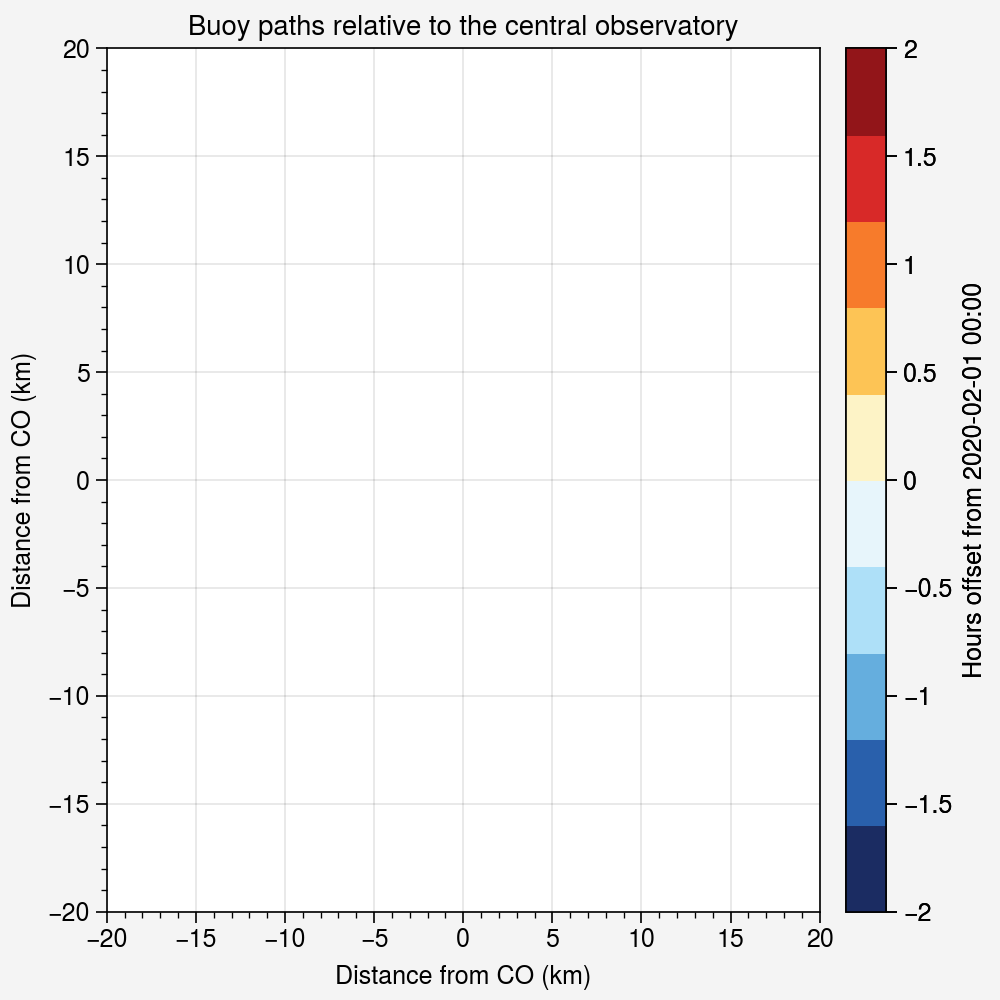

In [23]:
fig, ax = pplt.subplots(width=5, height=5)
x0 = buoy_data['CO1'].loc[cusps['CO1'], 'x']
y0 = buoy_data['CO1'].loc[cusps['CO1'], 'y']
m = ax.scatter(dfx.values.squeeze() - x0,
           dfy.values.squeeze() - y0,
               c=dt.values.squeeze(), edgecolor='k', N=10, vmin=-2, vmax=2, cmap='ColdHot', zorder=2, s=10)
# for buoy in buoys:
#     x, y = grab_path(cusps[buoy], buoy, buoy_data)
#     x += dfx[buoy].values - x0
#     y += dfy[buoy].values - y0
#     ax.plot(x/1e3, y/1e3, color='k', lw=0, marker='.', markersize=1)
ax.colorbar(m, label='Hours offset from 2020-02-01 00:00')
#ax.format(ylim=(87,88), xlim=(90,105))
ax.format(title='Buoy paths relative to the central observatory', ylim=(-20,20), xlim=(-20,20))
ax.format(xlabel='Distance from CO (km)', ylabel='Distance from CO (km)')
fig.save('../Images/buoy_drift_tracks_.jpg', dpi=300)


In [ ]:
dfx